# Fixed beam orientation

**Scott Prahl**

**Nov 2025**

Most lasers produce either stigmatic or simple astigmatic beams. In these cases, the fast and slow axes remain fixed with respect to the optical axis and do not change with propagation distance. For such systems, supplying a fixed rotation angle during analysis (phi_fixed) is often desirable and reduces variability.

Under normal operation, laserbeamsize analyzes the beam by locating its centroid, determining the major and minor diameters, and estimating the rotation angle ϕ of the beam ellipse. A region of interest (ROI) is then extracted: a rectangle sized to three times the diameters and aligned with ϕ. The beam parameters are recomputed iteratively until the diameters converge. By definition, the major diameter is always the larger of the two diameters, and the minor diameter is always the smaller value, regardless of orientation.

If a value for phi_fixed is provided, the image is rotated by this angle before analysis.  The analysis proceeds as above, except the major and minor axes are contrained to horizontal and vertical distances (in the rotated image). After finding the major and minor diameters of the beam, phi_fixed is assumed to be the angle between the horizontal axis and the major axis of the beam. 

In [1]:
%config InlineBackend.figure_format = 'retina'

import sys
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt

if sys.platform == "emscripten":
    import piplite

    await piplite.install("laserbeamsize")

import laserbeamsize as lbs

In [2]:
pixel_size_µm = 3.75  # pixel size in microns for the camera

if sys.platform == "emscripten":
    repo = "images/"
else:
    repo = "https://github.com/scottprahl/laserbeamsize/raw/main/docs/images/"

### A square beam

Let's start with the default parameters for `beam_size`.  The rotated fit that we see is somewhat surprising because our brains automatically recognize the square image and assign axes to it.  However, if you look at the cross-sections, then the fits are quite good.

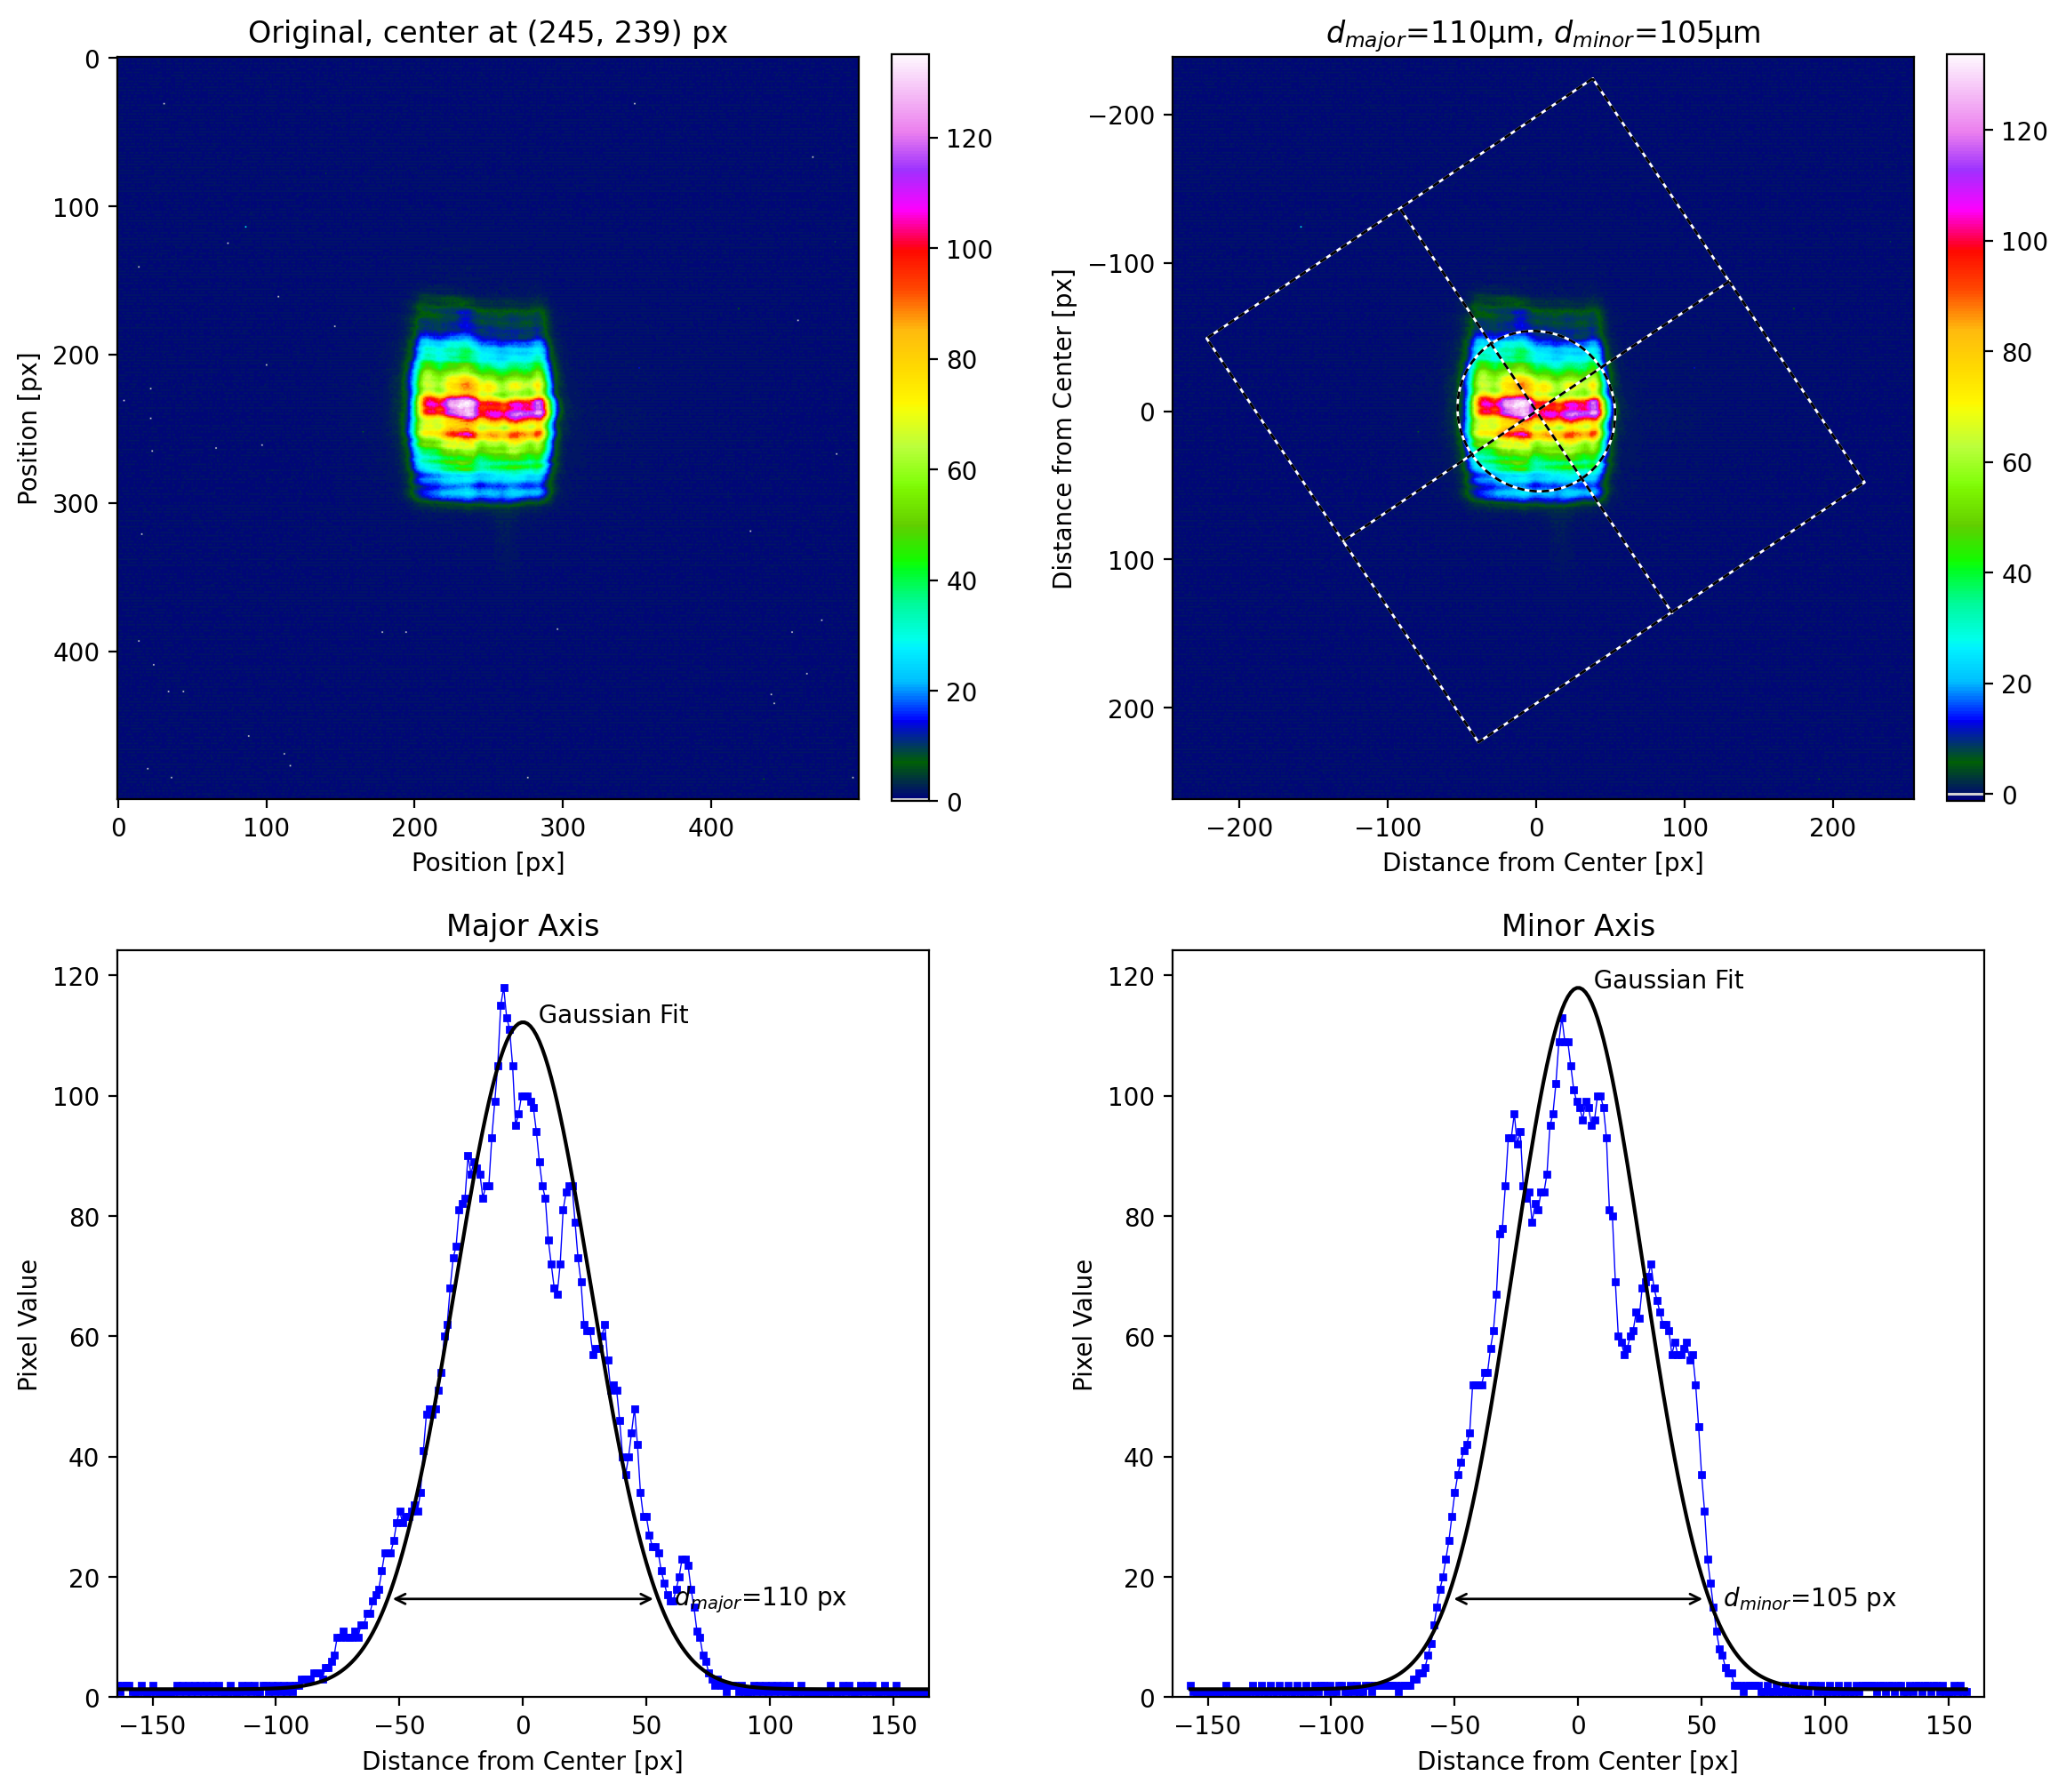

In [3]:
beam_color = iio.imread(repo + "astigmatic_beam.tif")
beam = beam_color[250:750, 500:1000, 0]

lbs.plot_image_analysis(beam)
plt.show()

What happens when we force the fast axis to be vertical?  In this case, we get an excellent fit to the fast axis but a mediocre one along the slow axis.  

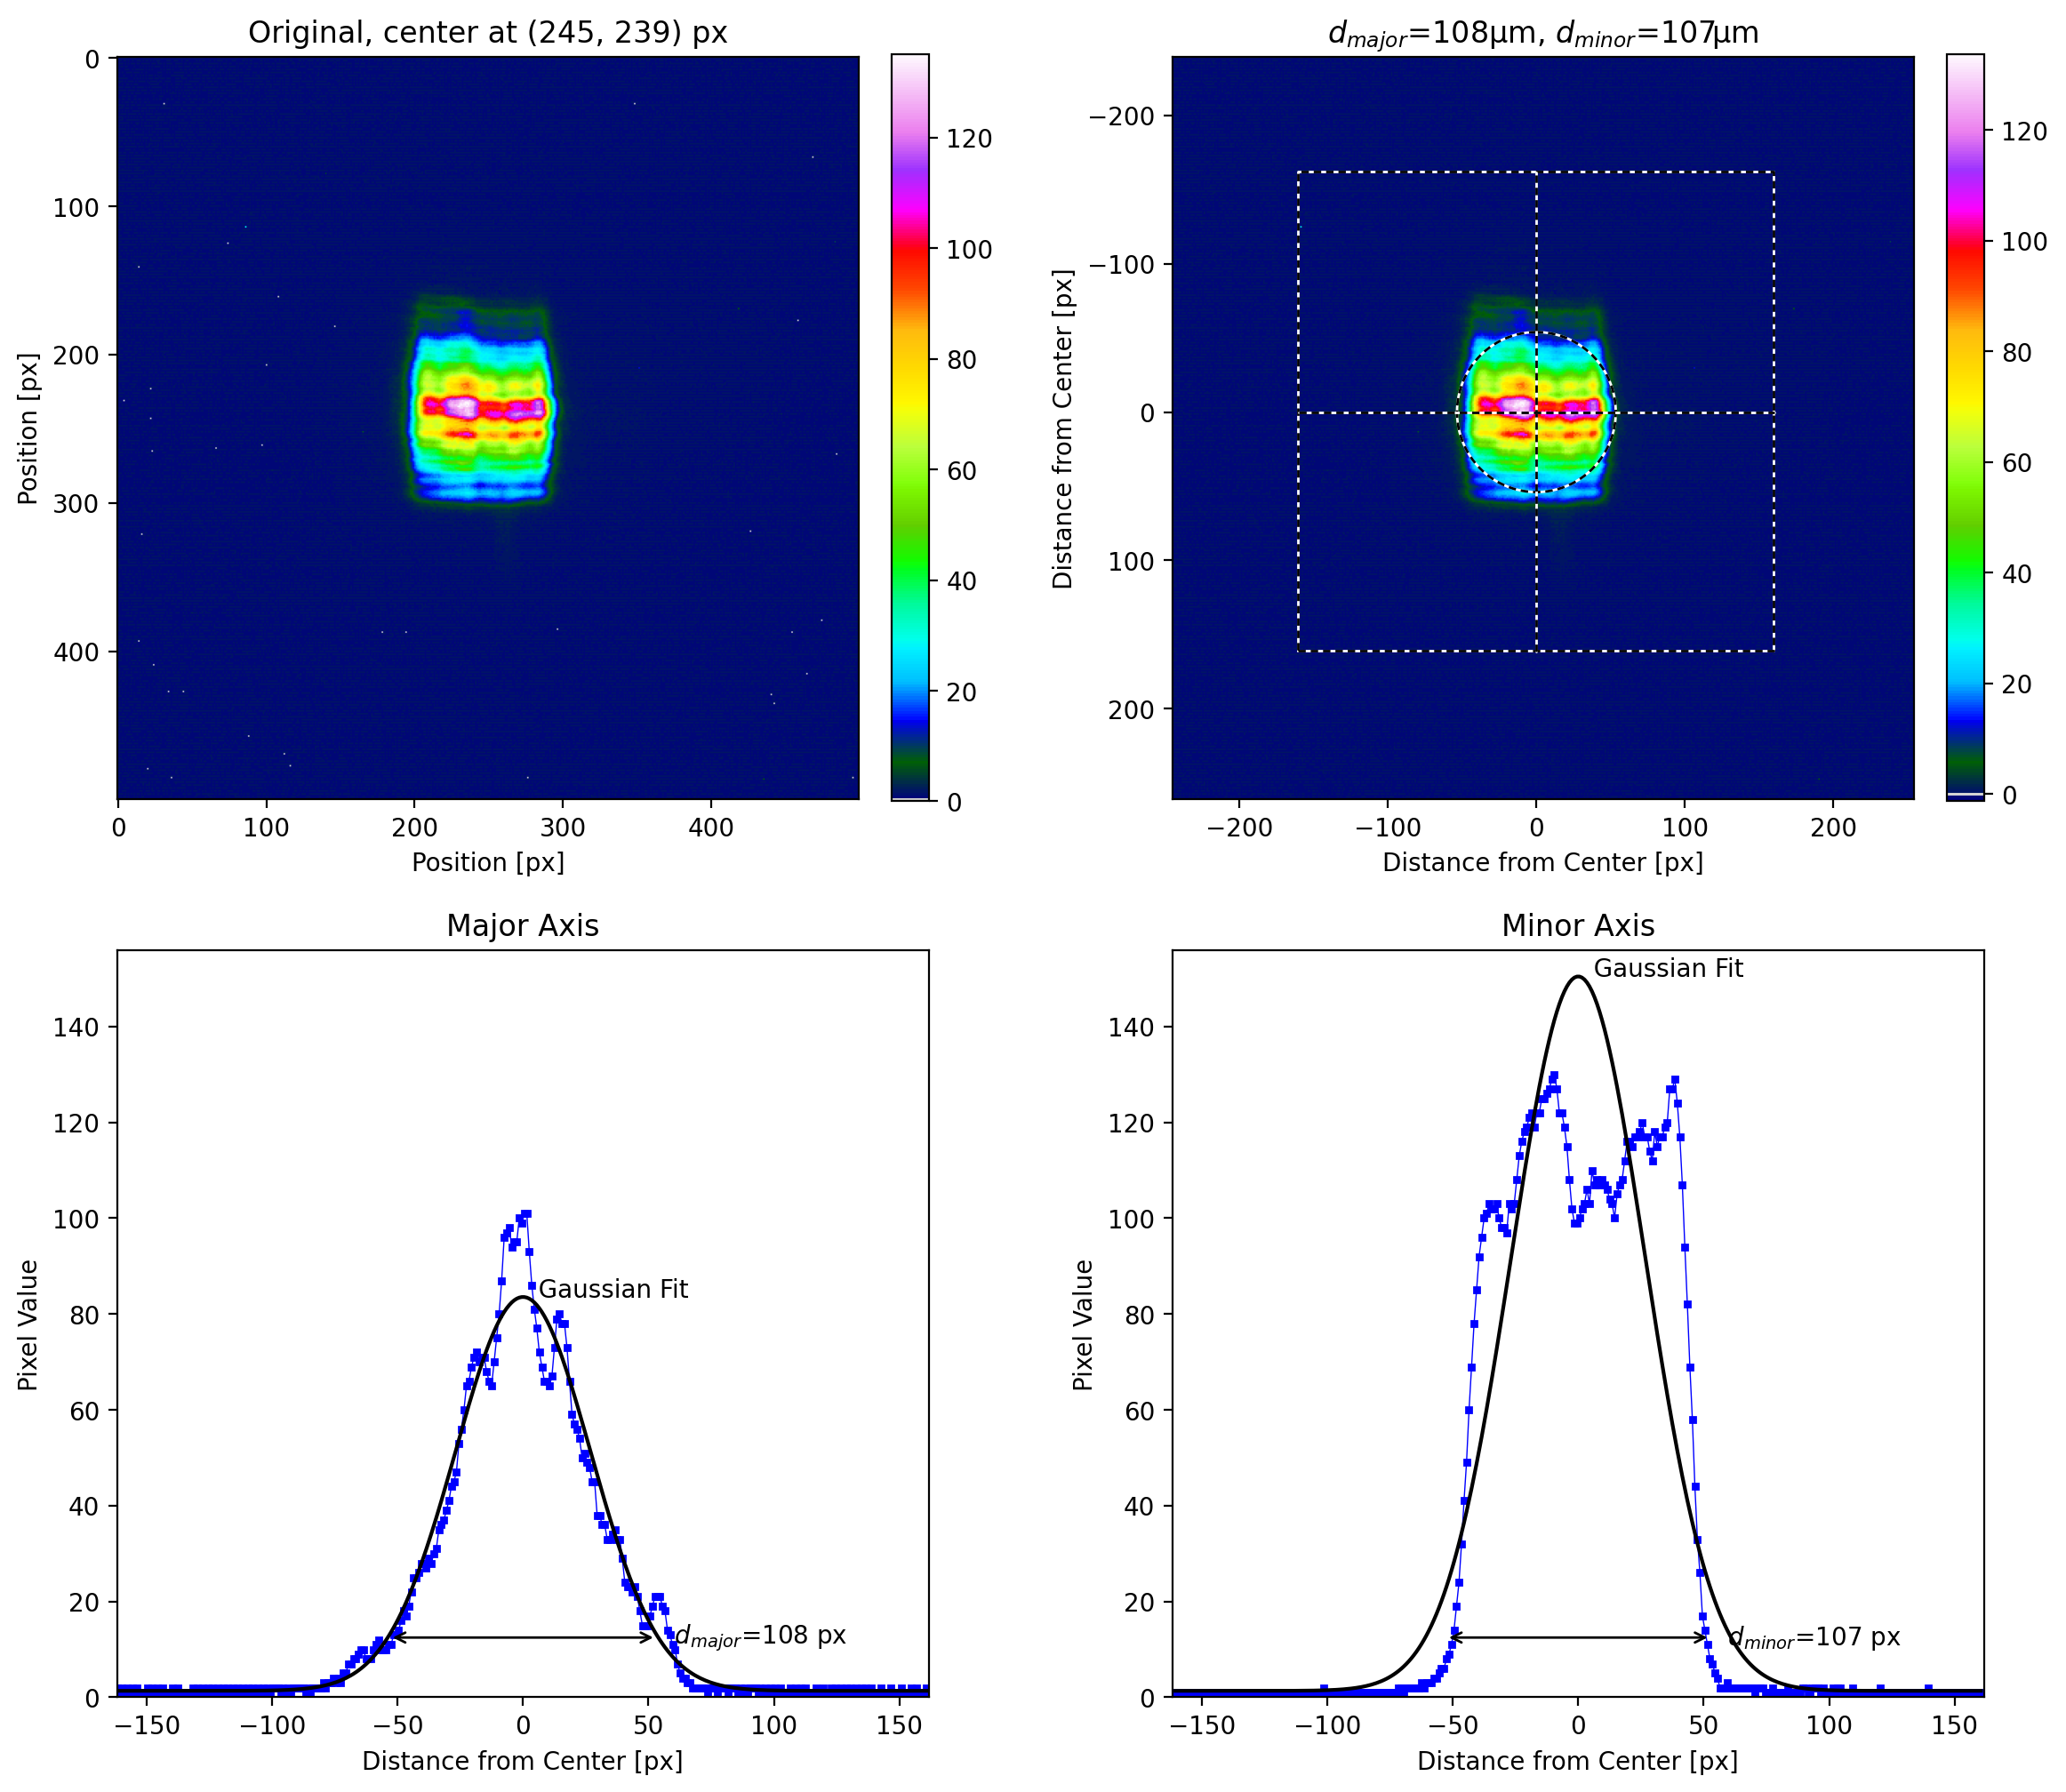

In [4]:
lbs.plot_image_analysis(beam, phi_fixed=np.radians(90))
plt.show()

### Analyzing a beam at multiple locations with fixed rotation

Here is a TEM01 beam that is rotated.  First we will look at an analysis using the defaults.  Then we will find the average rotation in all the images.  Finally, we will do an analysis using the average value.

Analysis of multiple images fail when `iso_noise=True`.  These are pretty noisy images.

In [5]:
lambda0 = 632.8e-9  # meters
z10 = np.array([247, 251, 259, 266, 281, 292]) * 1e-3  # image location in meters
filenames = [repo + "sb_%.0fmm_10.pgm" % (number * 1e3) for number in z10]

# the 12-bit pixel images are stored in high-order bits in 16-bit values
tem10 = [iio.imread(name) >> 4 for name in filenames]

# remove top to eliminate artifact
for i in range(len(z10)):
    tem10[i] = tem10[i][200:, :]

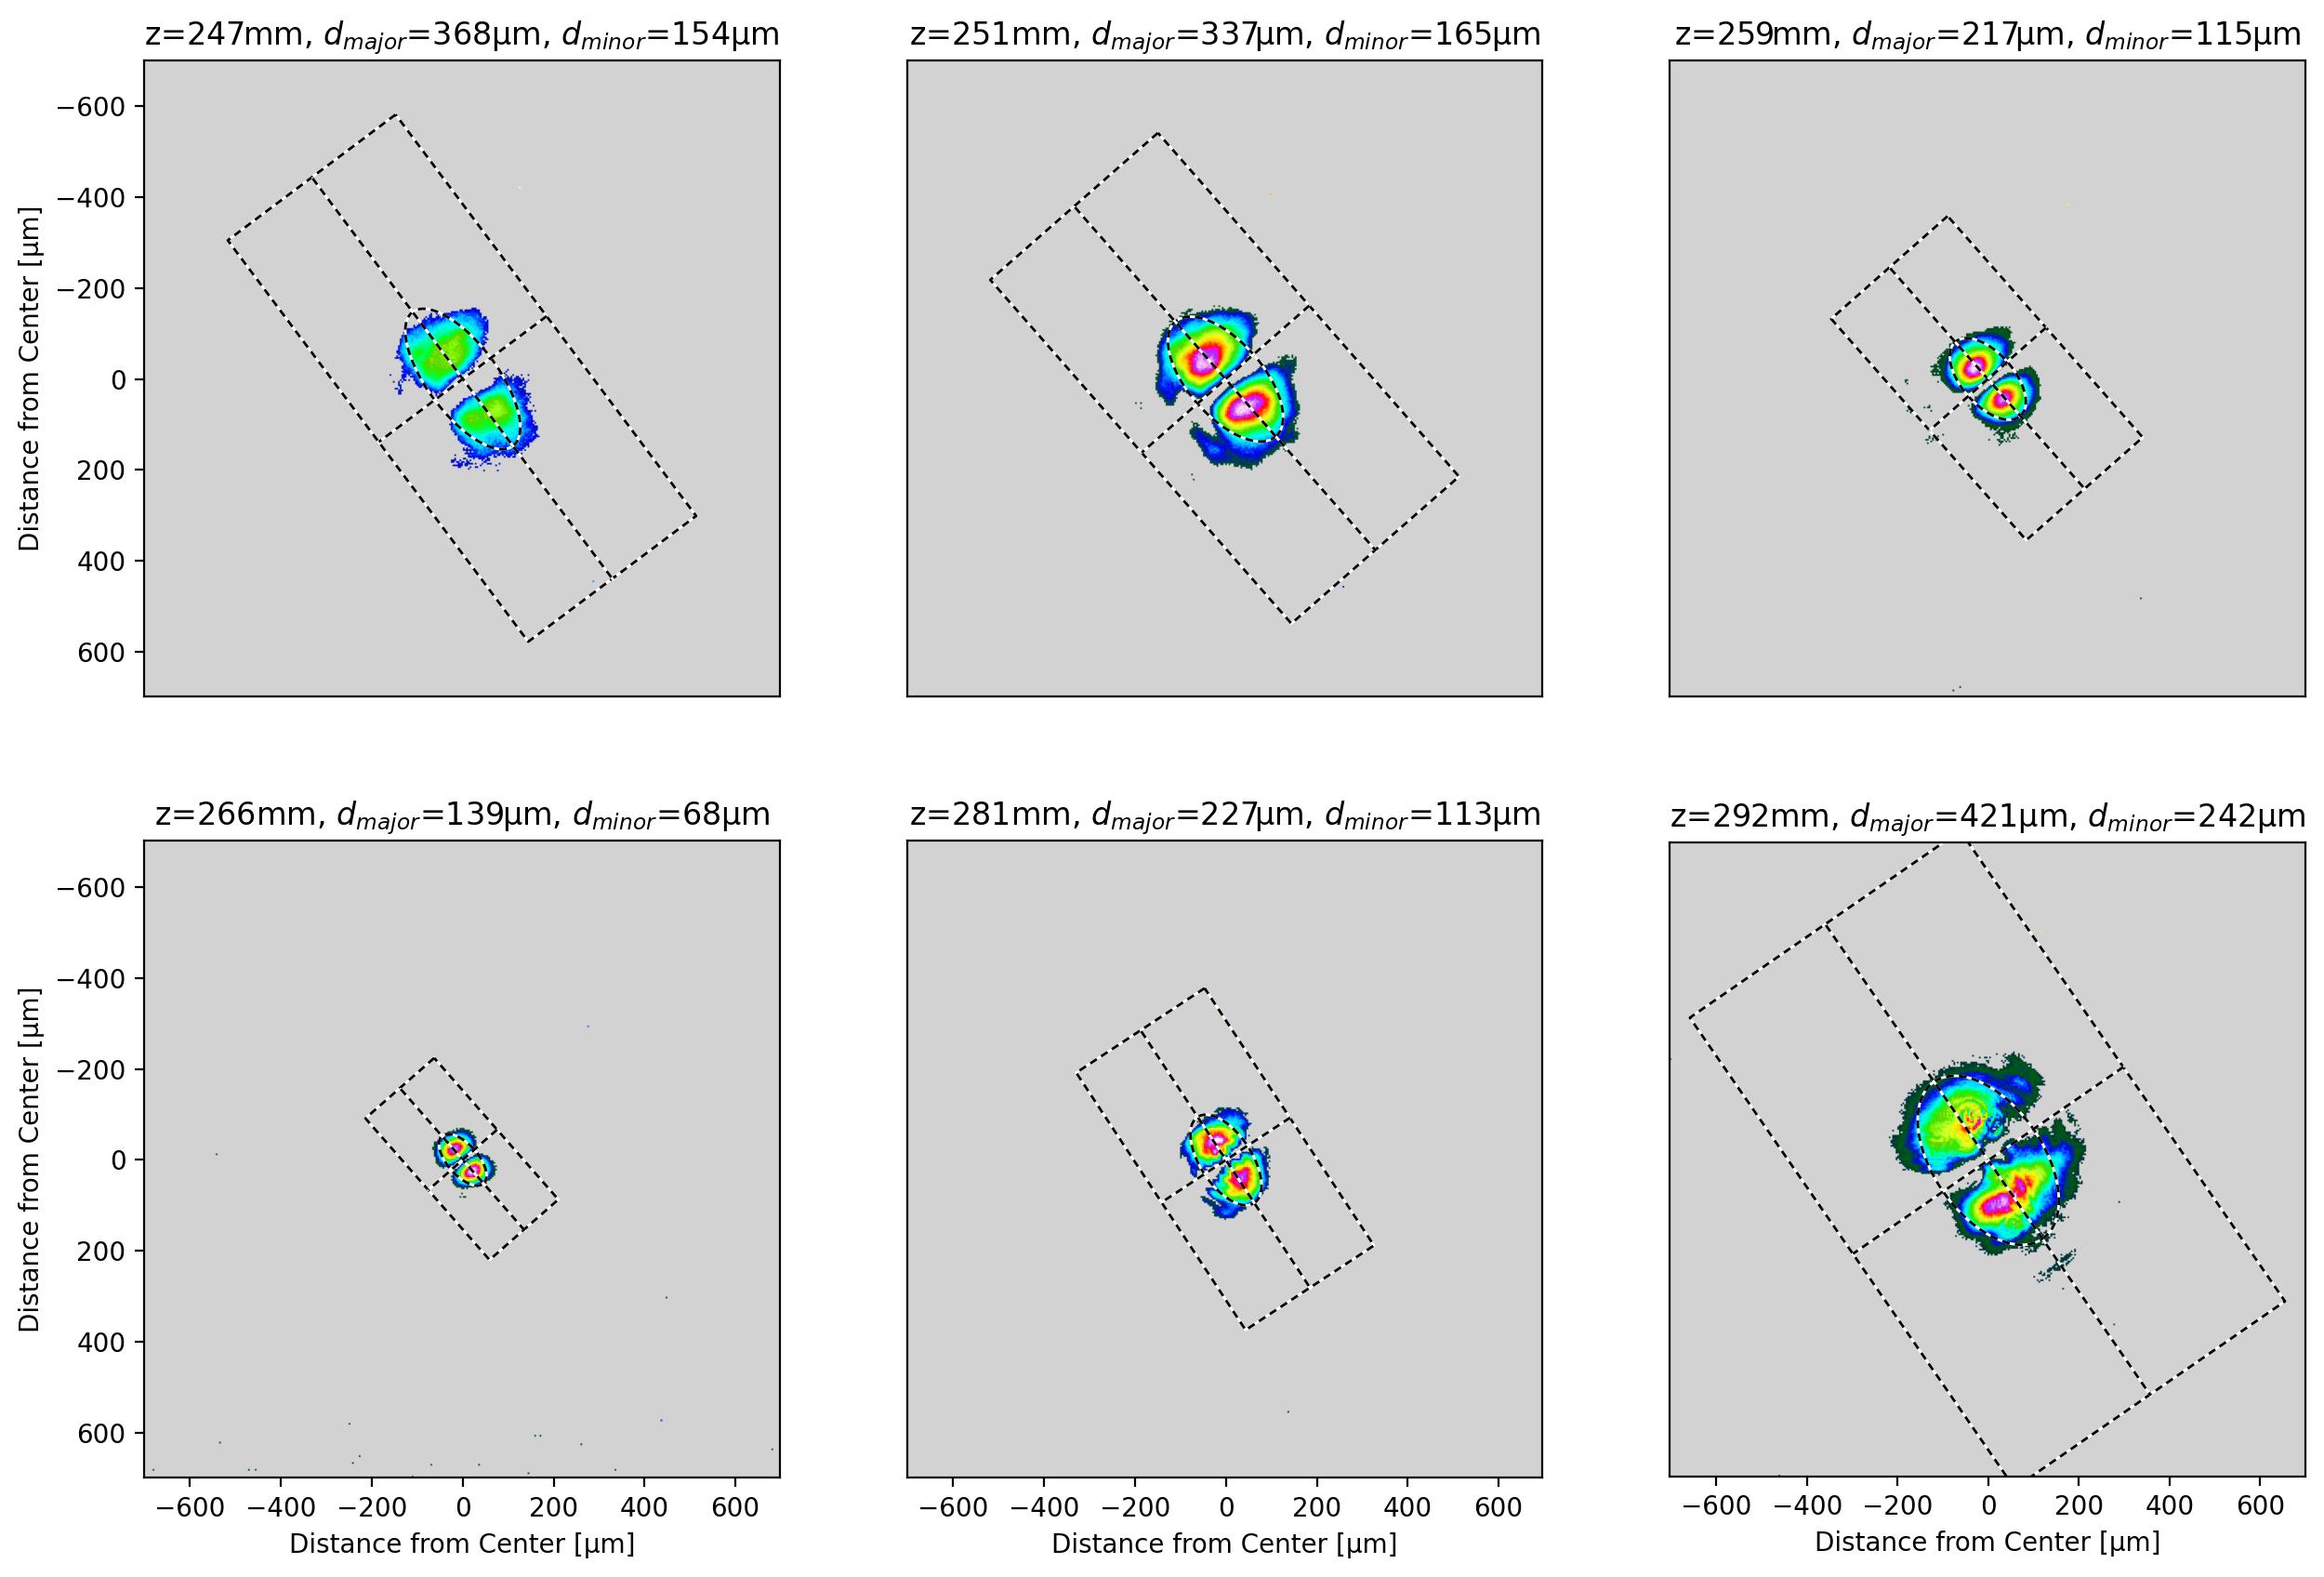

In [6]:
# find beam in all the images and create arrays of beam diameters
options = {
    "pixel_size": 3.75,
    "units": "µm",
    "crop": [1400, 1400],
    "z": z10,
    "iso_noise": False,
}
d_minor, d_major = lbs.plot_image_montage(tem10, **options)  # d_minor and d_major in microns
plt.show()

In [7]:
# find the average rotation

allphi = np.array([])

for im in tem10:
    xc, yc, d_major, d_minor, phi = lbs.beam_size(im, iso_noise=False)
    allphi = np.append(allphi, phi)

allphi = np.degrees(allphi)

print("%.1f±%.1f°" % (np.mean(allphi), np.std(allphi)))

-51.9±3.3°


Now just use this average angle for all fast and slow axis calculations

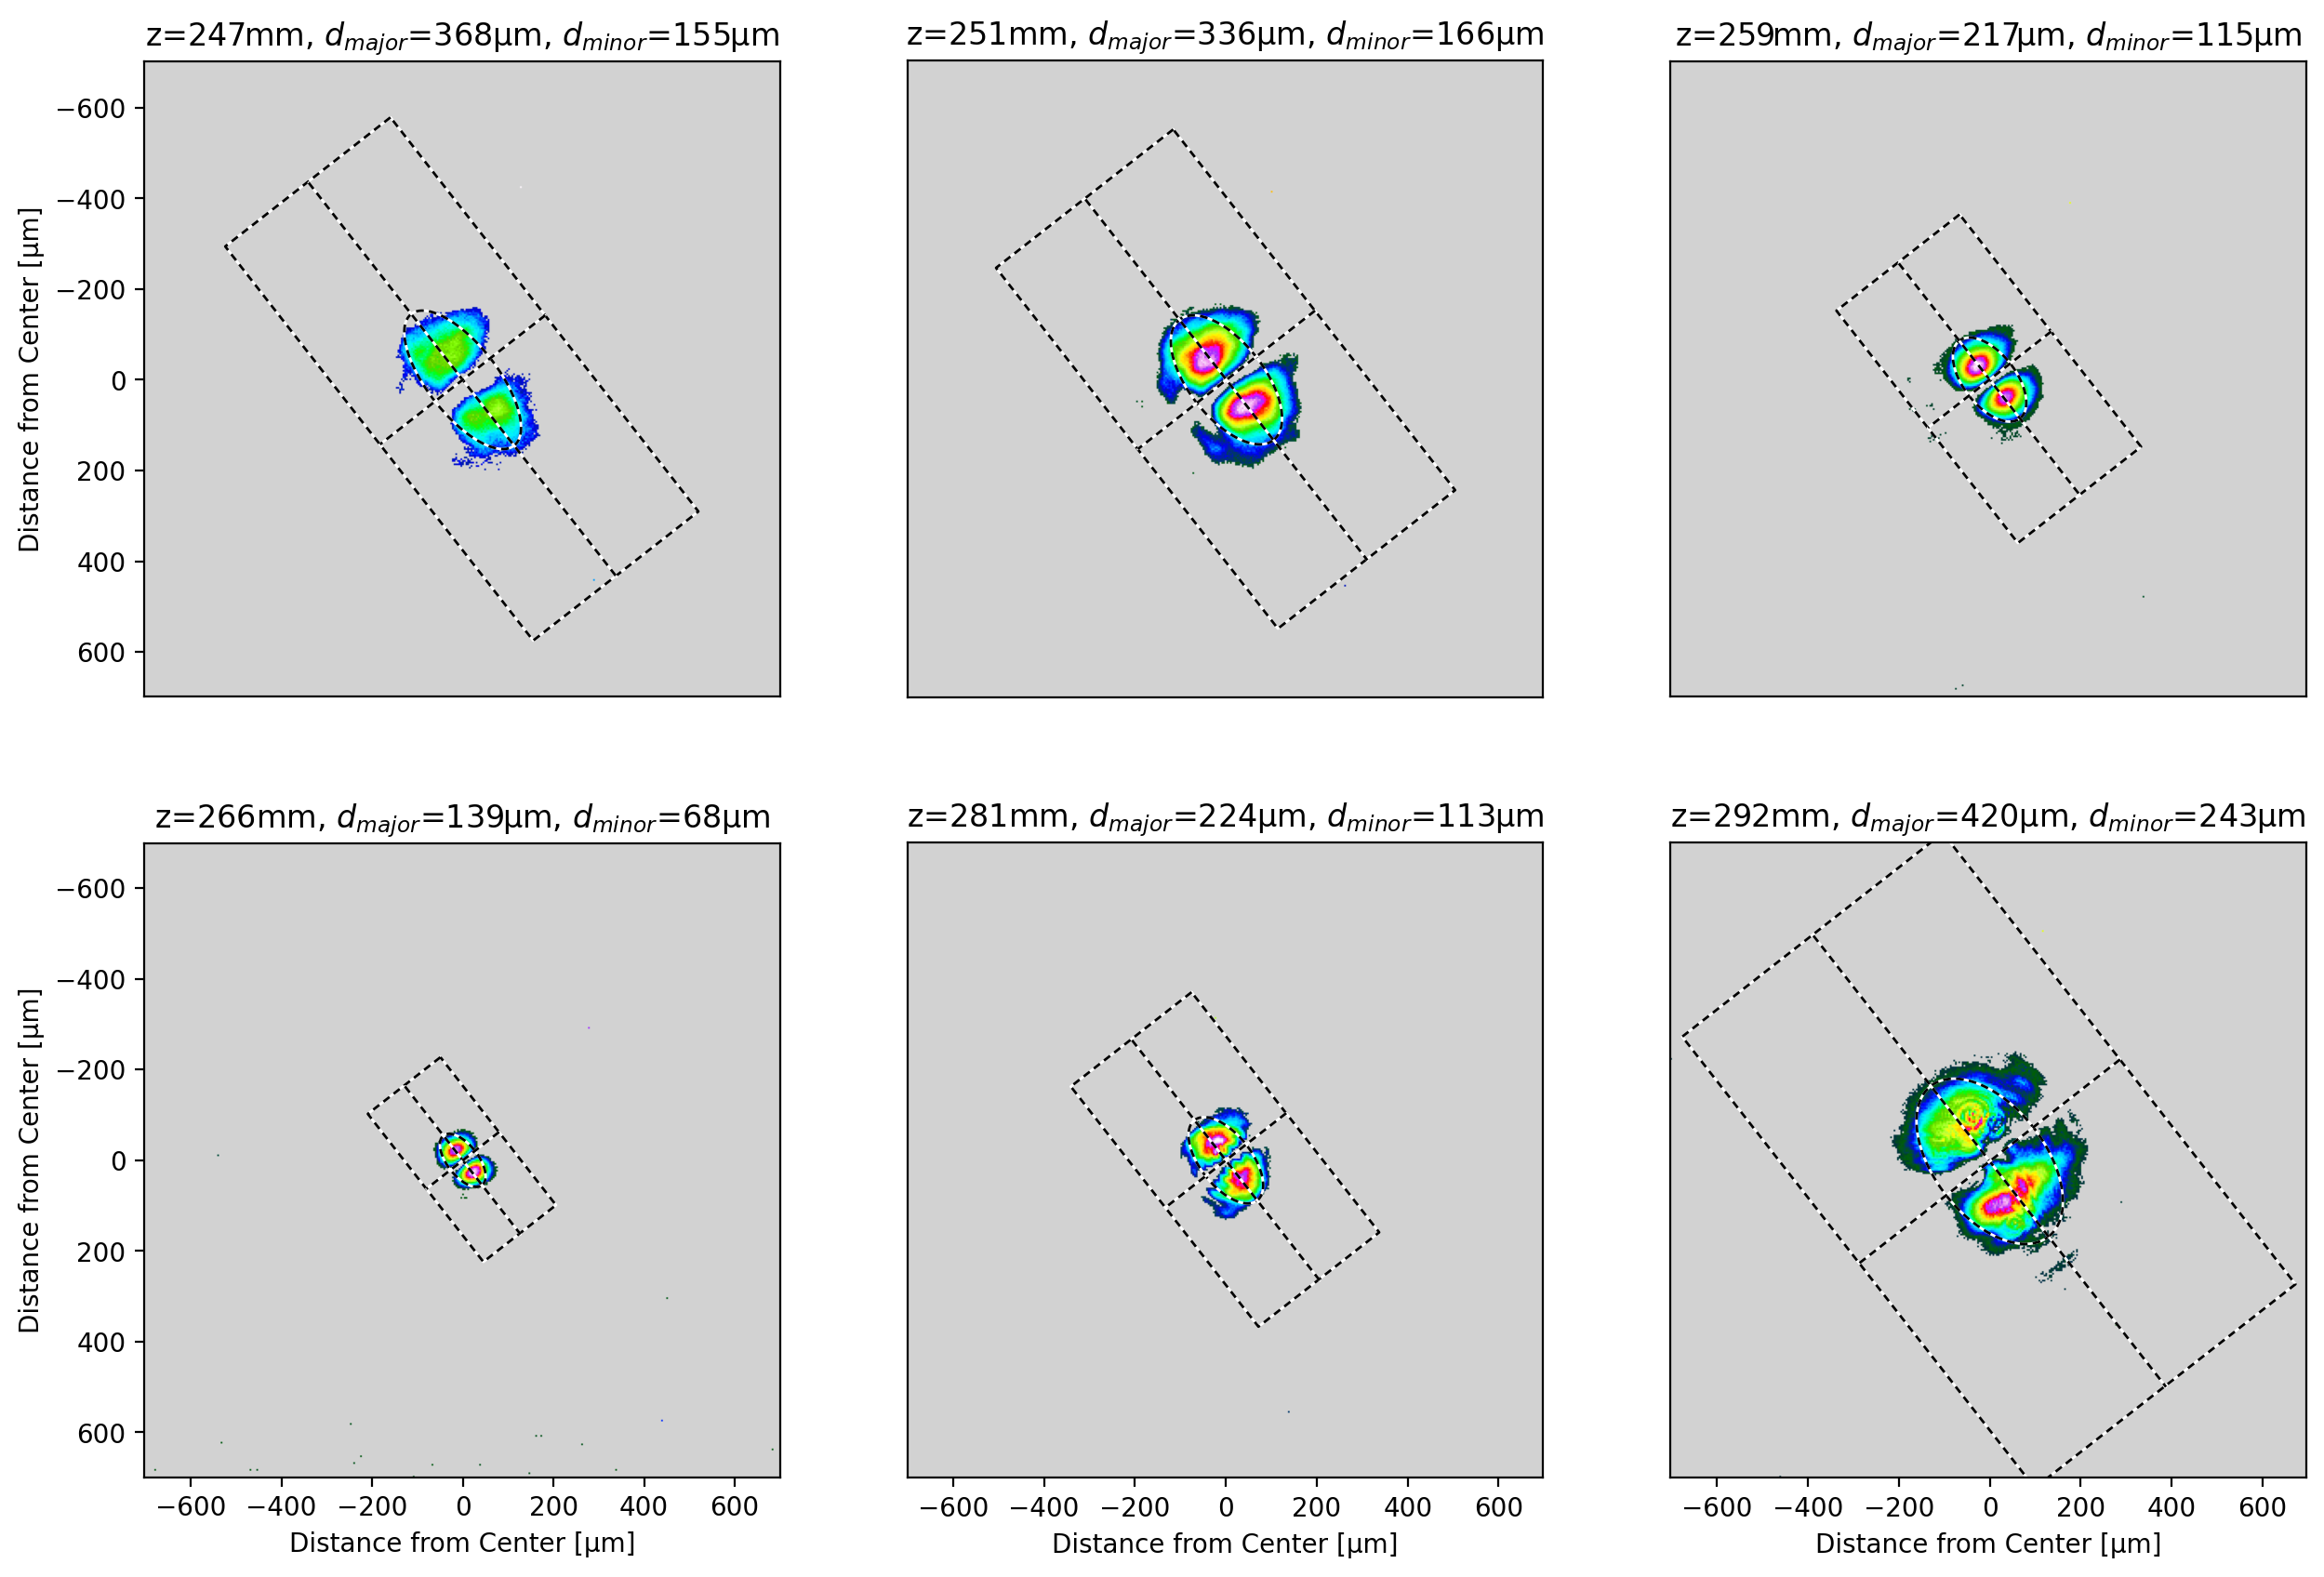

In [8]:
options = {
    "pixel_size": 3.75,
    "units": "µm",
    "crop": [1400, 1400],
    "z": z10,
    "phi_fixed": np.radians(-52),
    "iso_noise": False,
}
d_minor, d_major = lbs.plot_image_montage(tem10, **options)  # d_minor and d_major in microns
plt.show()

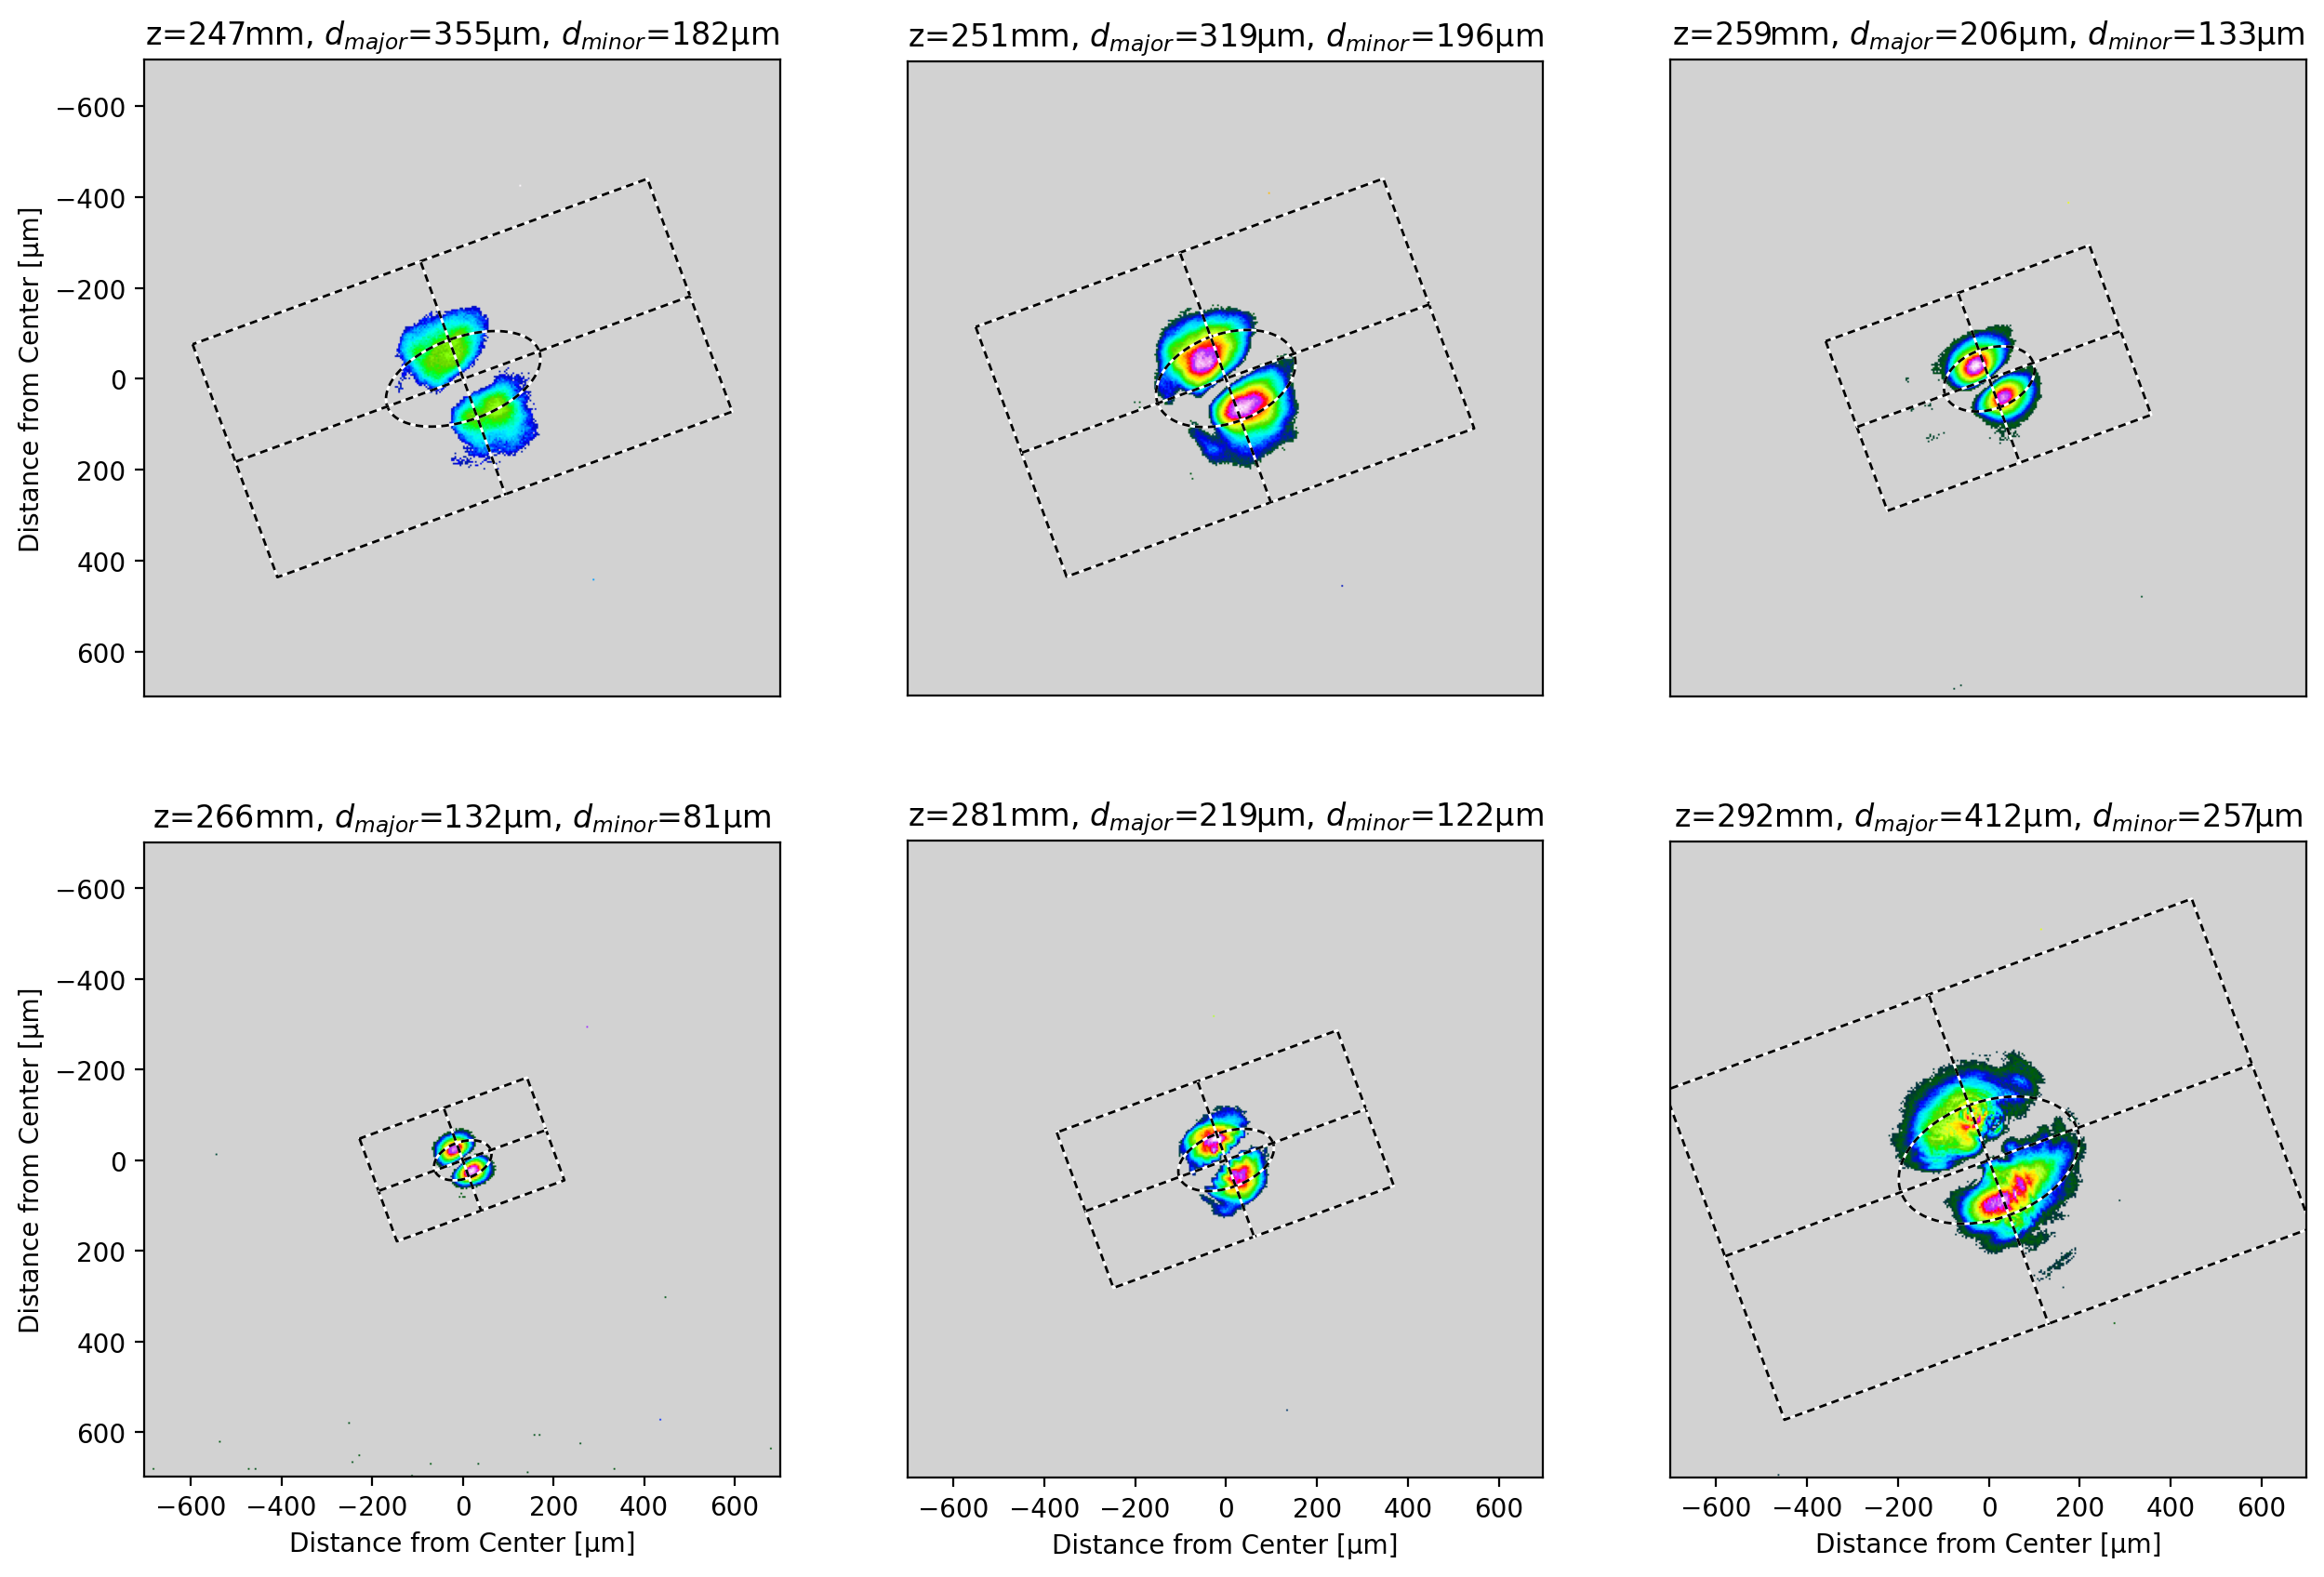

In [9]:
options = {
    "pixel_size": 3.75,
    "units": "µm",
    "crop": [1400, 1400],
    "z": z10,
    "phi_fixed": np.radians(20),
    "iso_noise": False,
}
d_minor, d_major = lbs.plot_image_montage(tem10, **options)  # d_minor and d_major in microns
plt.show()